<h1 style="text-align:center">基于LeNet5的手写数字识别</h1>

## 实验介绍

LeNet5 + MINST被誉为深度学习领域的“Hello world”。本实验主要介绍使用MindSpore在MNIST数据集上开发和训练一个LeNet5模型，并验证模型精度。

## 实验目的

- 了解如何使用MindSpore进行简单卷积神经网络的开发。
- 了解如何使用MindSpore进行简单图片分类任务的训练。
- 了解如何使用MindSpore进行简单图片分类任务的验证。

## 预备知识

- 熟练使用Python，了解Shell及Linux操作系统基本知识。
- 具备一定的深度学习理论知识，如卷积神经网络、损失函数、优化器，训练策略等。
- 了解华为云的基本使用方法，包括[OBS（对象存储）](https://www.huaweicloud.com/product/obs.html)、[ModelArts（AI开发平台）](https://www.huaweicloud.com/product/modelarts.html)、[Notebook（开发工具）](https://support.huaweicloud.com/engineers-modelarts/modelarts_23_0033.html)、[训练作业](https://support.huaweicloud.com/engineers-modelarts/modelarts_23_0046.html)等功能。华为云官网：https://www.huaweicloud.com
- 了解并熟悉MindSpore AI计算框架，MindSpore官网：https://www.mindspore.cn

## 实验环境

- MindSpore 0.2.0（MindSpore版本会定期更新，本指导也会定期刷新，与版本配套）；
- 华为云ModelArts：ModelArts是华为云提供的面向开发者的一站式AI开发平台，集成了昇腾AI处理器资源池，用户可以在该平台下体验MindSpore。ModelArts官网：https://www.huaweicloud.com/product/modelarts.html

## 实验准备

### 创建OBS桶

本实验需要使用华为云OBS存储实验脚本和数据集，可以参考[快速通过OBS控制台上传下载文件](https://support.huaweicloud.com/qs-obs/obs_qs_0001.html)了解使用OBS创建桶、上传文件、下载文件的使用方法。

> **提示：** 华为云新用户使用OBS时通常需要创建和配置“访问密钥”，可以在使用OBS时根据提示完成创建和配置。也可以参考[获取访问密钥并完成ModelArts全局配置](https://support.huaweicloud.com/prepare-modelarts/modelarts_08_0002.html)获取并配置访问密钥。

创建OBS桶的参考配置如下：

- 区域：华北-北京四
- 数据冗余存储策略：单AZ存储
- 桶名称：如ms-course
- 存储类别：标准存储
- 桶策略：公共读
- 归档数据直读：关闭
- 企业项目、标签等配置：免

### 数据集准备

MNIST是一个手写数字数据集，训练集包含60000张手写数字，测试集包含10000张手写数字，共10类。MNIST数据集的官网：[THE MNIST DATABASE](http://yann.lecun.com/exdb/mnist/)。

从MNIST官网下载如下4个文件到本地并解压：

```
train-images-idx3-ubyte.gz:  training set images (9912422 bytes)
train-labels-idx1-ubyte.gz:  training set labels (28881 bytes)
t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes)
t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)
```

### 脚本准备

从[课程gitee仓库](https://gitee.com/mindspore/course)上下载本实验相关脚本。

### 上传文件

将脚本和数据集上传到OBS桶中，组织为如下形式：

```
experiment_1
├── MNIST
│   ├── test
│   │   ├── t10k-images-idx3-ubyte
│   │   └── t10k-labels-idx1-ubyte
│   └── train
│       ├── train-images-idx3-ubyte
│       └── train-labels-idx1-ubyte
└── 脚本等文件
```

## 实验步骤（方案一）

### 创建Notebook

可以参考[创建并打开Notebook](https://support.huaweicloud.com/engineers-modelarts/modelarts_23_0034.html)来创建并打开本实验的Notebook脚本。

创建Notebook的参考配置：

- 计费模式：按需计费
- 名称：experiment_1
- 工作环境：Python3
- 资源池：公共资源
- 类型：Ascend
- 规格：单卡1*Ascend 910
- 存储位置：对象存储服务（OBS）->选择上述新建的OBS桶中的experiment_1文件夹
- 自动停止等配置：默认

> **注意：**
> - 打开Notebook前，在Jupyter Notebook文件列表页面，勾选目录里的所有文件/文件夹（实验脚本和数据集），并点击列表上方的“Sync OBS”按钮，使OBS桶中的所有文件同时同步到Notebook工作环境中，这样Notebook中的代码才能访问数据集。参考[使用Sync OBS功能](https://support.huaweicloud.com/engineers-modelarts/modelarts_23_0038.html)。
> - 打开Notebook后，选择MindSpore环境作为Kernel。

> **提示：** 上述数据集和脚本的准备工作也可以在Notebook环境中完成，在Jupyter Notebook文件列表页面，点击右上角的"New"->"Terminal"，进入Notebook环境所在终端，进入`work`目录，可以使用常用的linux shell命令，如`wget, gzip, tar, mkdir, mv`等，完成数据集和脚本的下载和准备。

> **提示：** 请从上至下阅读提示并执行代码框进行体验。代码框执行过程中左侧呈现[\*]，代码框执行完毕后左侧呈现如[1]，[2]等。请等上一个代码框执行完毕后再执行下一个代码框。

导入MindSpore模块和辅助模块：

In [ ]:
import os
# os.environ['DEVICE_ID'] = '0'
import matplotlib.pyplot as plt
import mindspore as ms
import mindspore.context as context
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.transforms.vision.c_transforms as CV

from mindspore import nn
from mindspore.train import Model
from mindspore.train.callback import LossMonitor

context.set_context(mode=context.GRAPH_MODE, device_target='Ascend')

### 数据处理

在使用数据集训练网络前，首先需要对数据进行预处理，如下：

In [ ]:
DATA_DIR_TRAIN = "MNIST/train" # 训练集信息
DATA_DIR_TEST = "MNIST/test" # 测试集信息

def create_dataset(training=True, num_epoch=1, batch_size=32, resize=(32, 32),
                   rescale=1/(255*0.3081), shift=-0.1307/0.3081, buffer_size=64):
    ds = ms.dataset.MnistDataset(DATA_DIR_TRAIN if training else DATA_DIR_TEST)
    ds = ds.map(input_columns="image", operations=[CV.Resize(resize), CV.Rescale(rescale, shift), CV.HWC2CHW()])
    ds = ds.map(input_columns="label", operations=C.TypeCast(ms.int32))
    ds = ds.shuffle(buffer_size=buffer_size).batch(batch_size, drop_remainder=True).repeat(num_epoch)
    
    return ds

对其中几张图片进行可视化，可以看到图片中的手写数字，图片的大小为32x32。

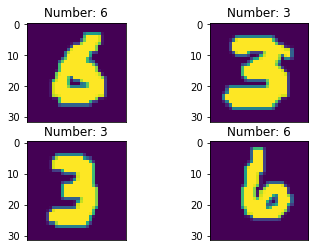

In [38]:
ds = create_dataset(training=False)
data = ds.create_dict_iterator().get_next()
images = data['image']
labels = data['label']

for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.imshow(images[i][0])
    plt.title('Number: %s' % labels[i])
    plt.xticks([])
plt.show()

### 定义模型

MindSpore model_zoo中提供了现成的LeNet5模型，但当前ModelArts平台上暂未集成该模块。模型结构如下图所示：

<img src="https://www.mindspore.cn/tutorial/zh-CN/master/_images/LeNet_5.jpg">

[1] 图片来源于http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf

In [ ]:
class LeNet5(nn.Cell):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 6, 5, stride=1, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1, pad_mode='valid')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(400, 120)
        self.fc2 = nn.Dense(120, 84)
        self.fc3 = nn.Dense(84, 10)
    
    def construct(self, input_x):
        output = self.conv1(input_x)
        output = self.relu(output)
        output = self.pool(output)
        output = self.conv2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = self.flatten(output)
        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        
        return output

### 训练

使用MNIST数据集对上述定义的LeNet模型进行训练。训练策略如下表所示，可以调整训练策略并查看训练效果，要求验证精度大于95%。

| batch size | number of epochs | learning rate | optimizer |
| -- | -- | -- | -- |
| 32 | 3 | 0.01 | Momentum 0.9 |

In [42]:
ds_train = create_dataset(num_epoch=3)
ds_eval = create_dataset(training=False)

net = LeNet5()
loss = nn.loss.SoftmaxCrossEntropyWithLogits(is_grad=False, sparse=True, reduction='mean')
opt = nn.Momentum(net.trainable_params(), 0.01, 0.9)

loss_cb = LossMonitor(per_print_times=1)

model = Model(net, loss, opt, metrics={'acc', 'loss'})
model.train(3, ds_train, callbacks=[loss_cb])
metrics = model.eval(ds_eval)
print('Metrics:', metrics)

epoch: 1 step: 1875 ,loss is 2.3086565
epoch: 2 step: 1875 ,loss is 0.22017351
epoch: 3 step: 1875 ,loss is 0.025683485
Metrics: {'acc': 0.9742588141025641, 'loss': 0.08628832848253062}


## 实验步骤（方案二）

### 代码梳理

创建训练作业时，运行参数会通过脚本传参的方式输入给脚本代码，脚本必须解析传参才能在代码中使用相应参数。如data_url和train_url，分别对应数据存储路径(OBS路径)和训练输出路径(OBS路径)。脚本对传参进行解析后赋值到`args`变量里，在后续代码里可以使用。

```python
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--data_url', required=True, default=None, help='Location of data.')
parser.add_argument('--train_url', required=True, default=None, help='Location of training outputs.')
parser.add_argument('--num_epochs', type=int, default=1, help='Number of training epochs.')
args, unknown = parser.parse_known_args()
```

MindSpore暂时没有提供直接访问OBS数据的接口，需要通过MoXing提供的API与OBS交互。将OBS中存储的数据拷贝至执行容器：

```python
import moxing as mox
mox.file.copy_parallel(src_url=args.data_url, dst_url='MNIST/')
```

如需将训练输出（如模型Checkpoint）从执行容器拷贝至OBS，请参考：

```python
import moxing as mox
mox.file.copy_parallel(src_url='output', dst_url='s3://OBS/PATH')
```

其他代码分析请参考方案一。

### 创建训练作业

可以参考[使用常用框架训练模型](https://support.huaweicloud.com/engineers-modelarts/modelarts_23_0238.html)来创建并启动训练作业。

创建训练作业的参考配置：

- 算法来源：常用框架->Ascend-Powered-Engine->MindSpore
- 代码目录：选择上述新建的OBS桶中的experiment_1目录
- 启动文件：选择上述新建的OBS桶中的experiment_1目录下的`main.py`
- 数据来源：数据存储位置->选择上述新建的OBS桶中的experiment_1目录下的MNIST目录
- 训练输出位置：选择上述新建的OBS桶中的experiment_1目录并在其中创建output目录
- 作业日志路径：同训练输出位置
- 规格：Ascend:1*Ascend 910
- 其他均为默认

启动并查看训练过程：

1. 点击提交以开始训练；
2. 在训练作业列表里可以看到刚创建的训练作业，在训练作业页面可以看到版本管理；
3. 点击运行中的训练作业，在展开的窗口中可以查看作业配置信息，以及训练过程中的日志，日志会不断刷新，等训练作业完成后也可以下载日志到本地进行查看；
4. 在训练日志中可以看到`epoch: 3 step: 1875 ,loss is 0.025683485`等字段，即训练过程的loss值；
5. 在训练日志中可以看到`Metrics: {'acc': 0.9742588141025641, 'loss': 0.08628832848253062}`字段，即训练完成后的验证精度。

## 实验小结

本实验展示了如何使用MindSpore进行手写数字识别，以及开发、训练和使用LeNet模型。通过对LeNet模型做几代的训练，然后使用训练后的LeNet模型对手写数字进行识别，识别准确率大于95%。即LeNet学习到了如何进行手写数字识别。